# Лабораторная работа №3
Визуализация данных о землетрясениях на карте и использование различных алгоритмов для их кластеризации

# Выполнили: Залесская Галина, Елькина Варвара, 16ПМИ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/quake.csv')

In [4]:
df.describe()

Focal depth     Latitude    Longitude      Richter
count  2178.000000  2178.000000  2178.000000  2178.000000
mean     74.359963     7.961997    54.914835     5.977181
std     116.467797    30.545583   118.875581     0.189426
min       0.000000   -66.490000  -179.960000     5.800000
25%      21.000000   -12.432500   -67.782500     5.800000
50%      39.000000     0.210000   122.100000     5.900000
75%      68.000000    36.480000   146.860000     6.100000
max     656.000000    78.150000   180.000000     6.900000

Узнаем немного данных, что получили. Абсолютное большинство землетрясений по силе распололожено в отрезке [5.8, 6.1]. Так же все землетрясения были относительно неглубоко, хотя разброс довольно сильный, это вызывает большие трудности с визуализацией глубины.

In [24]:
import folium
from folium.plugins import FastMarkerCluster
folium_map = folium.Map(
                        [-25, 0], tiles='openstreetmap', zoom_start=1)

FastMarkerCluster(data=list(zip(df['Latitude'].values, df['Longitude'].values))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)

folium_map

Интересная библиотека folium позволяет приближать и отдалять изображение. Если отдалить так, чтобы видеть все материки полностью, то можно увидеть, как точки от землетрясений сжались в 9 крупных областей с плотной их концентрацией. Но и видно 2 "выброса", а так же 3 слабонаселенные области (4, 4 и 5 землетрясений), помеченные зелеными иконками.  К сожалению, эта библиотека конфликтует с Basemap, так что приходится выбирать только одну для работы. И это будет Basemap, так как она кажется проще.

In [5]:
from mpl_toolkits.basemap import Basemap
from sklearn import preprocessing
from matplotlib.cm import rainbow

strong = df['Richter'].values
le = preprocessing.LabelEncoder()
colors = le.fit_transform(strong)

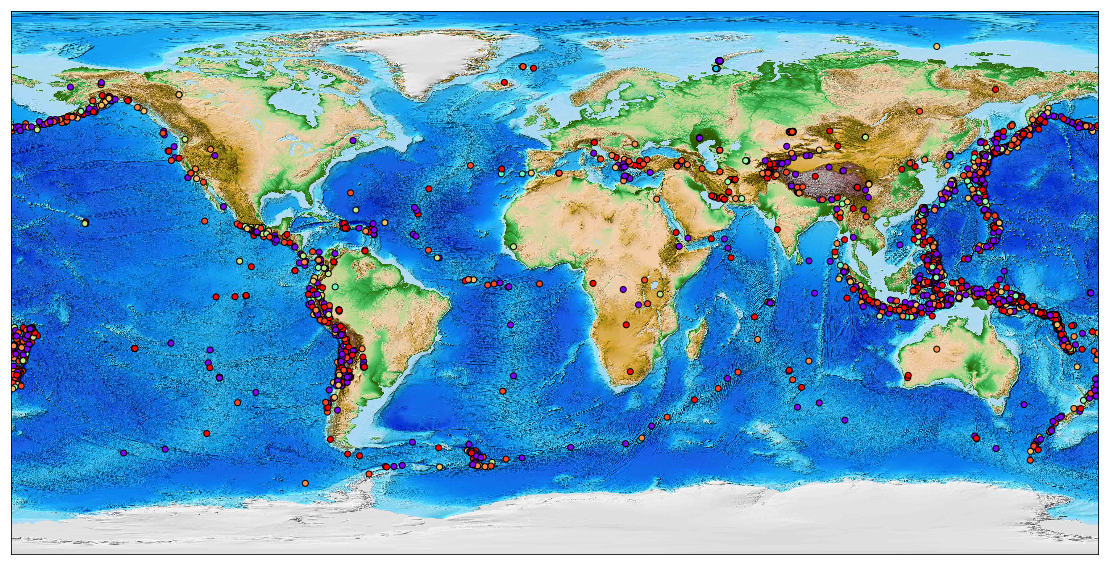

In [46]:
plt.figure(figsize=(45, 10))
m = Basemap()
m.etopo()

colormap = rainbow(np.linspace(0, 1, 12))    
x, y = m(df['Longitude'].values, df['Latitude'].values)
m.scatter(x, y, c=colormap[colors*(-1)], marker='o', edgecolors='black', linewidths=1)
plt.show()

При нанесении точек землетрясений на неподвижную карту, видно, что они идут вдоль границ литосферных плит, что совсем неудивительно. Цвет точки зависит от силы землетряссения, красная часть спектра - слабее, синяя - сильнее. Логикой было пожертвовано в угоду наглядности, так как если слабые землетрясения (коих большинство) отметить холодными цветами, то точки будут абсолютно неразличимы на фоне воды.

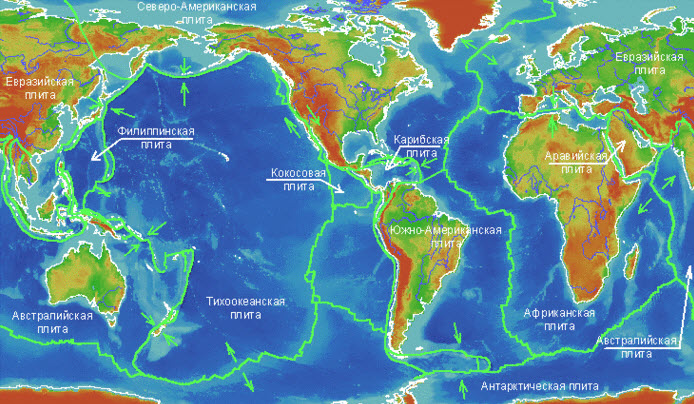

In [7]:
from IPython.display import Image
Image(filename='data/plit.jpg')

#  Иерархическая кластеризация 

In [9]:
old_df = df.copy()
df.loc[df.Longitude < 0, 'Longitude'] += 360.0
sh_df = df[['Latitude', 'Longitude']].values

Чтобы не разбивать точки, находящиеся в разных концах карты, но близко на земном шаре, нужно добавить к отрицательным долготам 360. Так место их разбиения придется на нулевую долготу со сравнительно небольшой концентрацией точек. Поэтому точность кластеризации не пострадает.

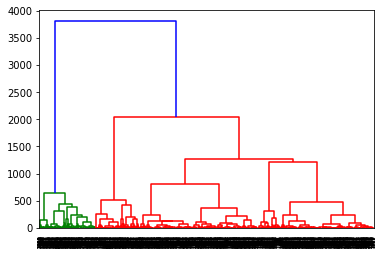

In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(sh_df, method='ward')
dendrogram(mergings)
plt.show()

Для определения оптимального числа кластеров, построим дендрограмму. По ней явно видно, что оно может варьироваться от 8 до 13 (в зависимости от степени дотошности), так как именно на этих этапах сливаются самые выраженные кластеры.

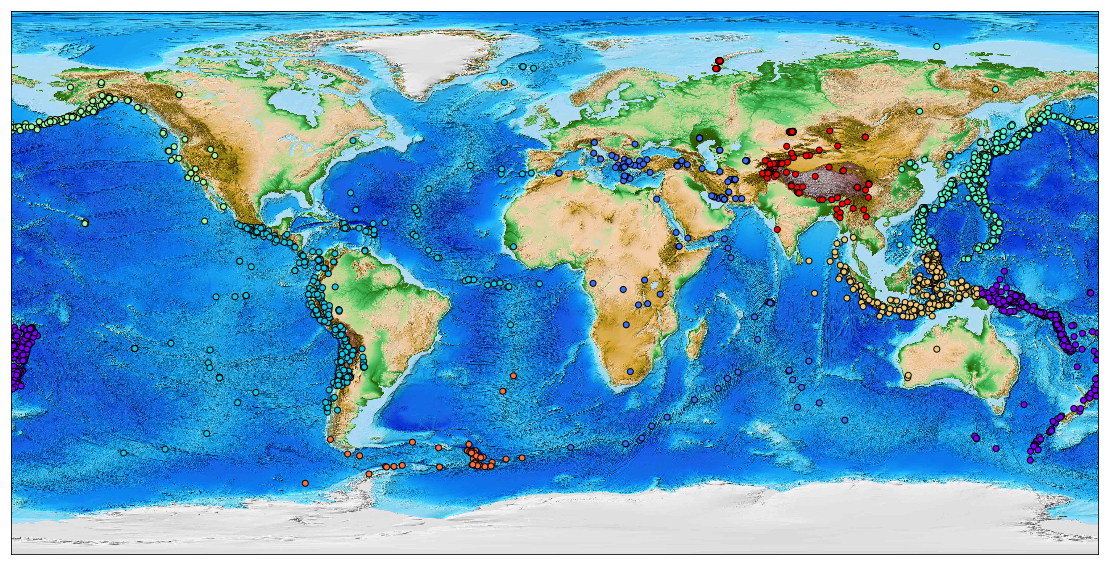

In [13]:
from sklearn.cluster import AgglomerativeClustering

aggCluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward').fit(sh_df) 

def Drawing(labels, k):
    plt.figure(figsize=(45, 10))
    m = Basemap()
    m.etopo()

    colormap = rainbow(np.linspace(0, 1, k+1))    
    x, y = m(old_df['Longitude'].values, old_df['Latitude'].values)
    m.scatter(x, y, c=colormap[labels], marker='o', edgecolors='black', linewidths=1)
    plt.show()
Drawing(aggCluster.labels_, max(np.unique(aggCluster.labels_)))

Для кластеризации используется только информация о географическом положении землетрясений, поэтому разбиение получается четким, красивым и наглядным. 

Замеченные еще на первичном анализе выбросы относятся к ближайшим к ним кластерам.

# K-means

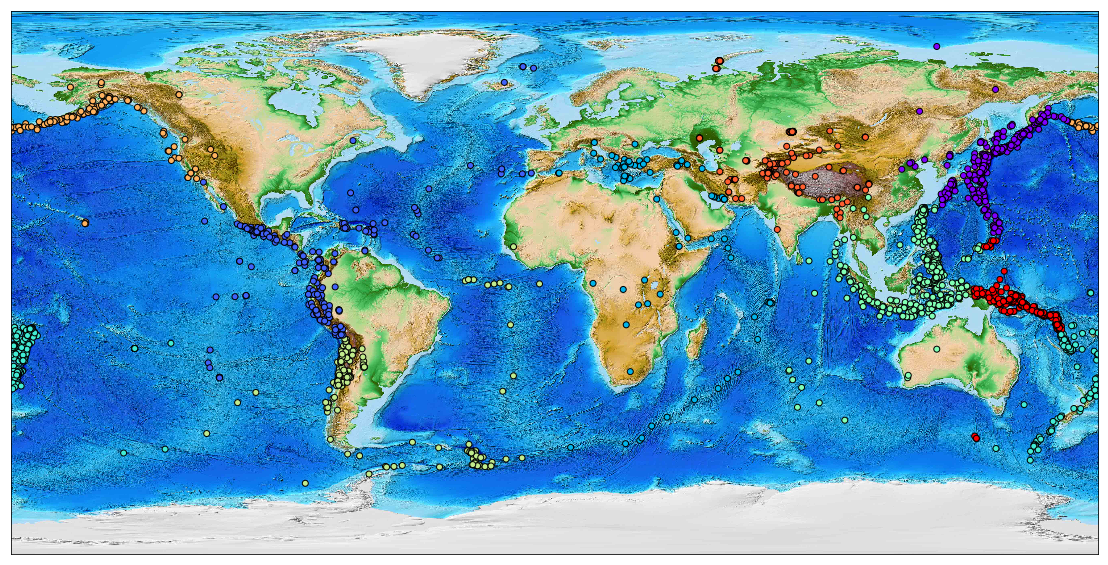

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(sh_df)
Drawing(kmeans.labels_, max(np.unique(kmeans.labels_)))

По графику каменистый осыпи видно, что заданный нами диапазон числа кластеров имеет место, но в точке 10, предположительно, будет лучшее разбиение.

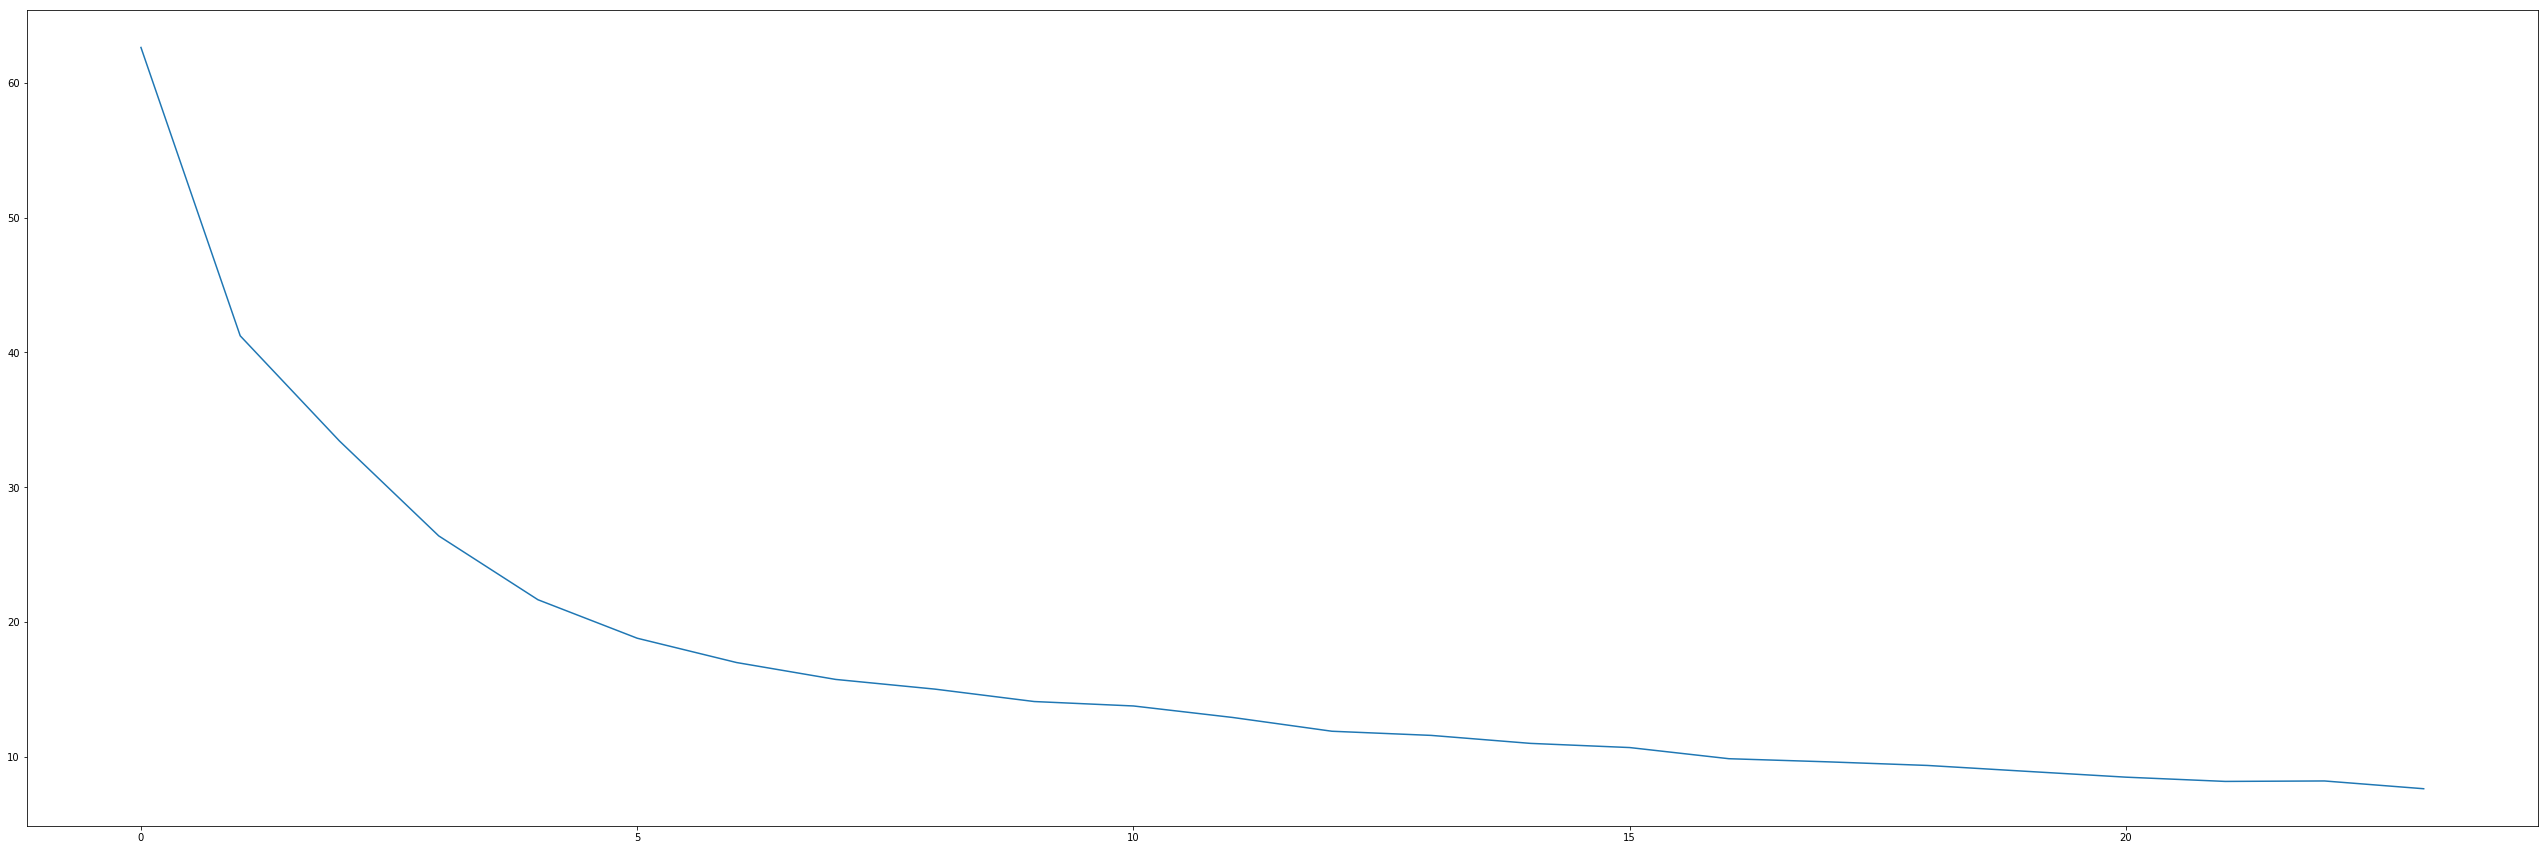

In [17]:
from scipy import cluster

centr_array = []
for i in range(1, 25):
    centr_array.append(cluster.vq.kmeans(sh_df,i))

plt.figure(figsize= (45, 15))
plt.plot([distortion for (cent, distortion) in centr_array])
plt.show()

K-means отлично предсказывает шарообразные кластеры небольшой формы. Поэтому на наших данных, представляющих из себя, скорее, переходящие линии, k-means нещадно тупит. 

# EM

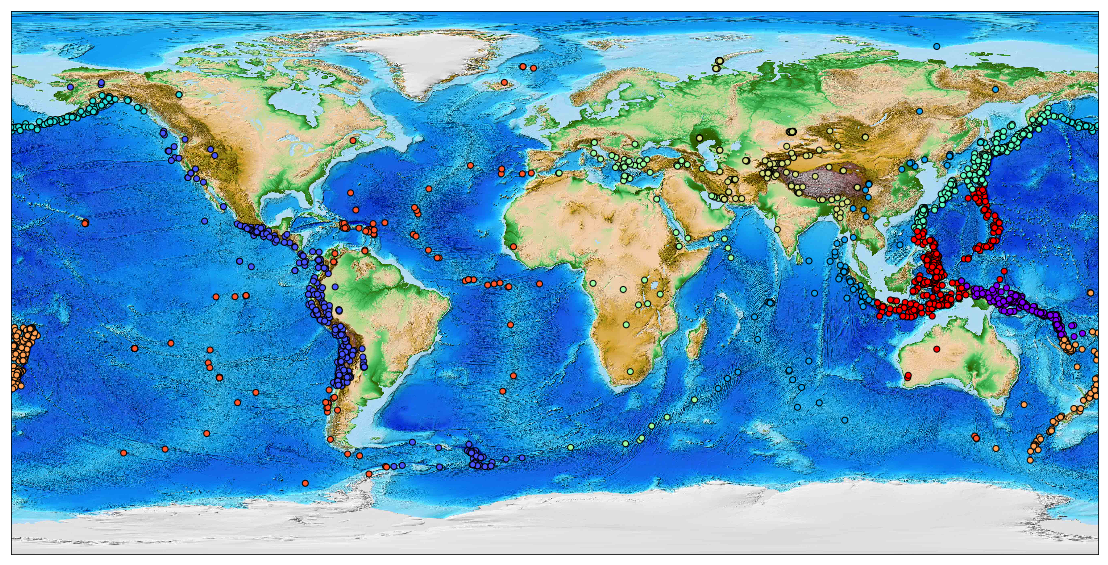

In [18]:
from sklearn.mixture import GaussianMixture

em = GaussianMixture(n_components=10).fit_predict(sh_df) 
Drawing(em, max(np.unique(em)))

EM обобщает K-means и здорово предсказывает вытянутые кластеры вроде наших. Несколько интересных вещей, как сработал алгоритм. В районе Японии два кластера частично смешались, образуя месево из двух едва различимых оттенков. А так же не очень очевидно, но кластеры рыжих точек (юг Тихого океана и приэкваториальная область Атлантического) и лавандовых (Южная Америка) так же пересеклись в виду своей вытянутости. 

# DBSCAN

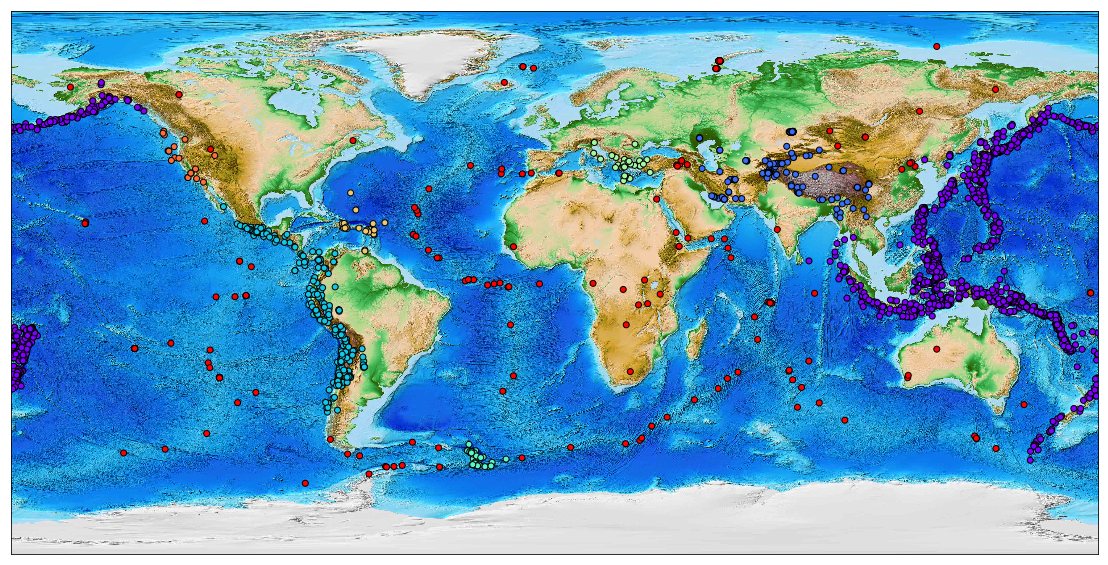

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=8, min_samples=10).fit(sh_df)
Drawing(dbscan.labels_, max(np.unique(dbscan.labels_)))

DBSCAN хорошо распознает шум, но для него сложно подобрать параметры для неоднородных групп со скоплениями разной плотности. Так же есть опасность, что алгоритм объединит разные кластеры через "мосты" с низкой плотностью точек. Примерно это и произошло в области Новой Зеландии, Гвинеи и Японии, хотя это разбиение кажется более, чем логичным. Разрозненные точки (красные), скорее всего, были отмечены как шумовые. Хотя они составляют некоторые кластеры с маленькой плотностью, но на фоне остальных, сильно сконцентрированных данных, они и правда кажутся шумом. 
Доказательством того, что кластеризация вполне удачная является 8 получившихся кластеров.

# Итог

1) Лучше всего показала себя иерархическая кластеризация, здорово обрабатывая выбросы и хорошо распознавая направленные линии.

2) Так же, на мой взгляд, DBSCAN показал очень интересное разбиение, но не оптимальное.

3) Алгоритмы же K-means и EM не очень подходят для данного датасета в виду того, что данные напоминают узкие полосы, а не скопление шарообразных кластеров. 

4) Разбиение на 9-10 кластеров оказалось самым наглядным и информативным.